### LaneDetection
**차선 유지 보조 시스템**이란 자동차가 주행중인 차로를 벗어났을 때 운전자에서 경고를 주는 HMI와 본래 주행 중이던 차로로 복귀하는 제어 장치이다. 초기의 차선 유지 보조 시스템은 차선이탈 경고 장치 기능 위주였고 최근 차선 이탈 복귀 장치 기능으로 확대되었다.  
현재 HW쪽으로는 직접 실험해 볼 수 있는 환경이 안되므로 **차선 이탈 경고 장치인 Lane Departure Warning(LDW)에서 사용할 수 있는 Lane Detection구현을 목표로 한다.**  
LaneDetection이란 차선을 찾아주는 Algorithm이다.  
이러한 Algorithm은 LDW에서 충분히 사용될 수 있을 것이라 생각된다.
OpenCV로 구현하였으며 아래 링크를 참조하여 구현하였습니다.  

**참조 링크**  
Youtube 링크: <a href="https://www.youtube.com/watch?v=eLTLtUVuuy4">OpenCV Python Tutorial - Find Lanes for Self-Driving Cars (Computer Vision Basics Tutorial)</a><br>

Image 링크: <a href="https://github.com/rslim087a/road-image/blob/master/test_image.jpg">rslim087a GitHub</a><br>

Video 링크: <a href="https://github.com/rslim087a/road-video/blob/master/test2.mp4">rslim087a GitHub</a><br>

#### 필요한 라이브러리 임포트

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets 
import IPython.display as display
from ipywidgets import Layout, Button, Box, Layout, Image, IntSlider, AppLayout

### 데이터 확인

In [2]:
cap = cv2.VideoCapture('./data/test_video.mp4')
img = cv2.imread('./data/test_image.jpg')

if(not cap.isOpened()):
    print('Error opening video')

height,width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))

wImg1 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 
wImg2 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 

items = [wImg1, wImg2]
box = Box(children=items)

display.display(box)
wImg1.value = cv2.imencode(".jpeg", img)[1].tostring()
while True:
    try:
        retval, frame = cap.read()
        if not retval:
            break
        
        wImg2.value = cv2.imencode(".jpeg", frame)[1].tostring()
    
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

Box(children=(Image(value=b'', layout="Layout(border='solid')", width='30%'), Image(value=b'', layout="Layout(…

### Edge Detection
실제 Lane 을 추출하기 위하여 Edge를 추출한다.  
Edge를 추출하기 위한 과정은 다음과 같다.  
1. GrayScale로 변환
2. Noise제거를 위한 Gaussian Blur 사용(Edge 성분은 남기면서 Blur효과를 사용하기 위하여 Gaussian Blur 선택)
3. Canny Edge Detection으로서 Edge 추출

Edge Detection에대해 모르시는 분들은 아래 링크 참조  
Gaussian Blur, Canny Edge Detection: <a href="https://wjddyd66.github.io/opencv/2019/10/29/OpenCV(5).html">OpenCV-영상 공간 필터링</a><br>

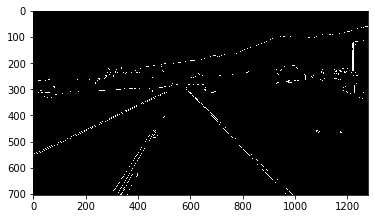

In [4]:
lane_image = np.copy(img)

# Edge Detection
def canny(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    canny = cv2.Canny(blur,50,150)
    return canny

# 결과 확인
canny_image = canny(lane_image)
plt.imshow(canny_image, cmap='gray')

### 관심영역 지정
위의 그림을 보게 되면, 원근법에 의해서 Line이 일정한 크기를 가진다고 생걱할 수 있다.  
이러한 특징 때문에 Video로 들어오는 Image에서 특정영역을 관심영역으로 지정하여 좀 더 정확히 Filtering을 하는 과정을 거친다.  
관심영역 지정은 아래 그림과 같다.  
<img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/OpenCV/124.PNG" height="100%" width="100%" /><br>

위에서 추출한 Edge 중 관심영역에 존재하는 Edge를 추출한다.

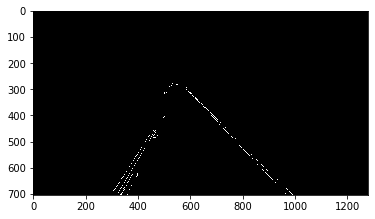

In [5]:
#관심영역 지정
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([[(200,height),(1100,height),(550,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask,triangle,255)
    masked_image = cv2.bitwise_and(image,mask)
    return masked_image

# 결과 확인
cropped_image = region_of_interest(canny_image)
plt.imshow(cropped_image, cmap='gray')

### Hough 변환에 의한 직선검출
위의 결과로서 원하는 구역에서의 Edge(차선)을 얻었다.  
Hough 변화에의해 Edge에서의 직선을 구한다.  
Hough 변환: <a href="https://wjddyd66.github.io/opencv/2019/10/30/OpenCV(6).html">OpenCV-영상 분할</a><br>

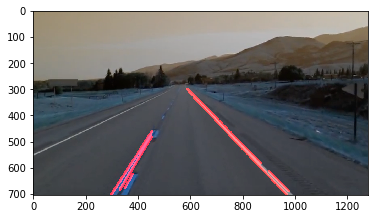

In [6]:
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            try:
                x1,y1,x2,y2 = line
            except:
                x1,y1,x2,y2 = line[0]
                
            cv2.line(line_image,(x2,y2),(x1,y1),(255,0,0),10)
    return line_image
    
lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength=40,maxLineGap=5)
result_line = []

for i in range(0,len(lines)):
    result_line.append(lines[i])
    
line_image = display_lines(lane_image,lines)
combo_image = cv2.addWeighted(lane_image,0.8,line_image,1,1)


# 결과 확인
plt.imshow(combo_image)

### Optimazation
Hough 변화에 의해 추출한 사진을 살펴보자  
**차선을 기준으로 오른쪽 차선은 흰색으로 쭉 이어져서 Line을 잘 추출한다.**  
**하지만 차선을 기준으로 왼쪽 차선은 점선으로 표현되어 있어 먼 거리의 경우는 Detect 하지 못하는 문제가 발생한다.**  

**따라서 여러 Line이 아닌 기울기를 기준으로 왼쪽 차선과 오른쪽 차선을 나눈 뒤 평균값으로 직선 1개로 나타내고, 또한 들어오는 Image의 전체 표시가 아닌 잘 Detect할 수 있는 범위까지를 Detect하여 최종적인 Line Detect를 찾아낸다.**

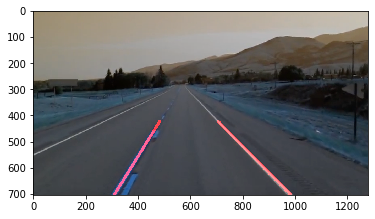

In [7]:
def average_slope_intercept(image,lines):
    left_fit = []
    right_fit = []
    
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        slope = ((y1-y2)/(x1-x2))
        intercept = y1-slope*x1
       
        if slope < 0:
            left_fit.append((slope,intercept))
        else:
            right_fit.append((slope,intercept))
       
            
    left_fit_average = np.average(left_fit,axis=0)
    right_fit_average = np.average(right_fit,axis=0)
    
    left_line = make_coordinates(image,left_fit_average)
    right_line = make_coordinates(image,right_fit_average)
    
    lines = [left_line,right_line]
    
    return lines
    
def make_coordinates(image,line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
            
    points = [x1,y1,x2,y2]
    return points

lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength=40,maxLineGap=5)
averaged_lines = average_slope_intercept(lane_image,lines)
line_image = display_lines(lane_image,averaged_lines)
combo_image = cv2.addWeighted(lane_image,0.8,line_image,1,1)

# 결과 확인
plt.imshow(combo_image)

### 결과확인

In [11]:
cap = cv2.VideoCapture('./data/test_video.mp4')

if(not cap.isOpened()):
    print('Error opening video')

height,width = (int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))

wImg1 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 
wImg2 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%") 
wImg3 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%")
wImg4 = widgets.Image(layout = widgets.Layout(border="solid"), width="30%")

items = [wImg1, wImg2]
box = Box(children=items)

items = [wImg3, wImg4]
box2 = Box(children=items)

display.display(box,box2)

while True:
    try:
        _,frame = cap.read()
        if not retval:
            break
        
        canny_image = canny(frame)
        cropped_image = region_of_interest(canny_image)
        lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength=40,maxLineGap=5)
        averaged_lines = average_slope_intercept(lane_image,lines)
        line_image = display_lines(lane_image,averaged_lines)
        combo_image = cv2.addWeighted(lane_image,0.8,line_image,1,1)
        
        wImg1.value = cv2.imencode(".jpeg", frame)[1].tostring()
        wImg2.value = cv2.imencode(".jpeg", canny_image)[1].tostring()
        wImg3.value = cv2.imencode(".jpeg", cropped_image)[1].tostring()
        wImg4.value = cv2.imencode(".jpeg", combo_image)[1].tostring()
    
    except KeyboardInterrupt:
        break
        
if cap.isOpened():
    cap.release()

Box(children=(Image(value=b'', layout="Layout(border='solid')", width='30%'), Image(value=b'', layout="Layout(…

Box(children=(Image(value=b'', layout="Layout(border='solid')", width='30%'), Image(value=b'', layout="Layout(…

Line Detection을 OpenCV를 통하여 간단하게 구현해보았다.  

위에서 구현한 Line Detection에 대한 **한계점에 대해서 몇가지 생각해 보자.**
- 관심영역 지정: 결국에 삼각형의 모양으로 검출하고자하는 영역을 지정하였다. 이러한 문제는 실제 블렉박스에서 들어오는 Frame에 대한 Line Detection을 불가능하다는 것을 의미한다.(제일 큰 문제이다.)
- Optimazation: 차선을 기준으로 왼쪽 Line의 길이를 제한을 하였다. 이러한 문제점으로 인하여 차량의 속도는 매우 제한적이 될 수 밖에 없다.

간단히 생각해봤을 경우 2가지의 큰 문제가 발생하게 된다.  
DeepLearning으로 다시 Line Detection을 구현하고 이러한 문제점이 해결되었는지 확인해보자.